In [1]:
import wandb
wandb.init(project="sde")

wandb: Currently logged in as: holybayes (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [2]:
import os
import sys
sys.path.append('../')
from utils.preprocessing import prominence_preprocessing, DiffTransformer, LowessSmoothTransformer
from utils.init import manual_seed
from utils.optim import LinearScheduler, Ranger
from utils.metrics import EMAMetric, covering, f_measure

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

from models import LatentSDE
import json
import pandas as pd
from glob import glob
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':35})


import numpy as np
import torch
from tqdm.auto import tqdm
from torch import distributions, nn, optim
from models import LatentSDE
import torchsde
import io
from PIL import Image

In [3]:
args = wandb.config
args.data_type = 'segmented_cosine'
args.kl_anneal_iters = 800
args.train_iters = 1000
# args.train_iters = 10
args.postprocessing = True
args.batch_size = 512
args.likelihood = 'laplace' # normal
args.scale = 0.5
args.lag = 5
args.origin_smooth = 1e-2
args.diff_smooth = 4e-2
# args.origin_smooth = 1e-6
# args.diff_smooth = 1e-6
args.seed = 5
args.opt = 'adam'
args.lr = 1e-2
args.n_pos_encodings = 5 # number of positional encodings
args.margin = 5

plot_args = {'linewidth': 3}

In [4]:
def plt2pil(fig=None):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    if fig is None:
        fig = plt.gcf()
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Data

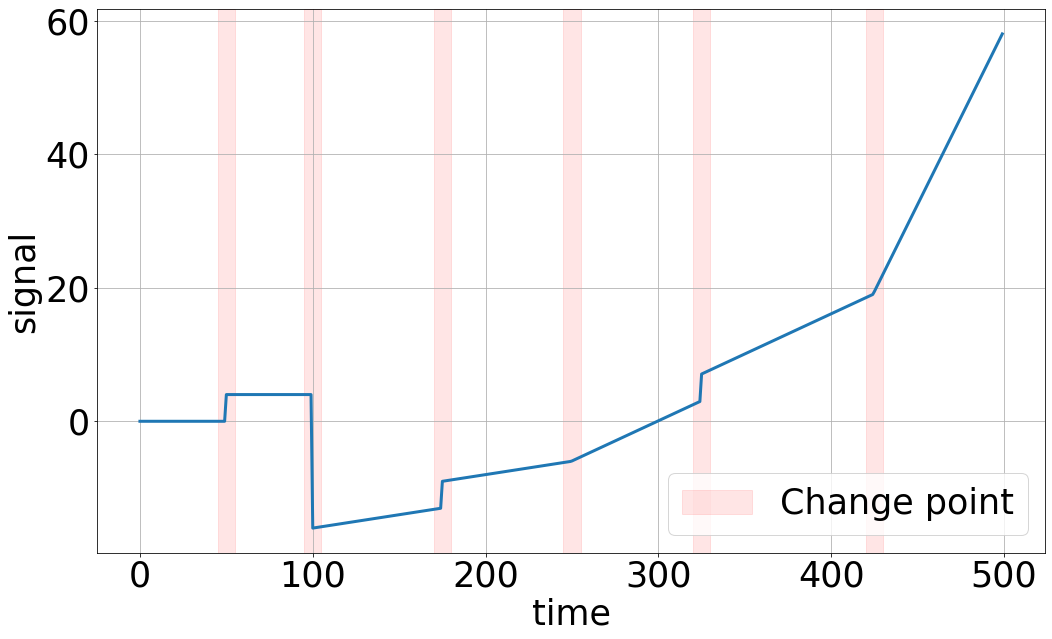

In [5]:
# dataset_name = '../../datasets_cp/data/synthetic/synthetic_dataset_9/'

# with open(os.path.join(dataset_name, 'descriptions.json'), 'r') as f:
#     descriptions = json.load(f)
    
sample_name = 'Step in 1 component'
# sample_id = descriptions.index(sample_name)
dataset_name = '../../datasets_cp/data/synthetic/synthetic_dataset_8/'
sample_id = 0
# dataset_name = '../../datasets_cp/data/tcpd/apple/'
# sample_id = 0


df = pd.read_csv(os.path.join(dataset_name, f'sample_{sample_id}.csv'))
ts, X, y = 2*math.pi*df.Time.values/df.Time.max(), df[[col for col in df.columns if 'X' in col]].values, df[[col for col in df.columns if 'Label' in col]].max(1).values


D = X.shape[1]

plt.figure(figsize=(17,10))

for d in range(D):
    plt.clf()
    plt.plot(X[:, d], **plot_args);
    plt.grid()
    plt.ylabel('signal')
    plt.xlabel('time')

    for point in np.argwhere(y==1).squeeze():
        plt.axvspan(point-args.margin, point+args.margin, alpha=0.1, color='red', label='Change point')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    wandb.log({f"Data/original_data (dim {d})": wandb.Image(plt2pil())})

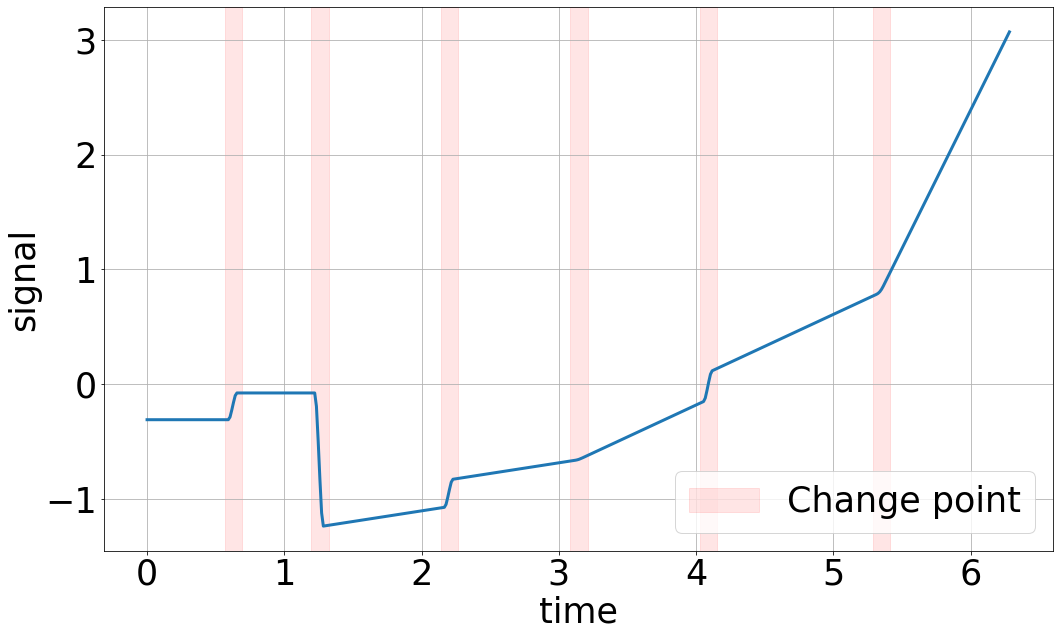

In [6]:
plt.figure(figsize=(17,10))
preprocessor = make_pipeline(LowessSmoothTransformer(args.origin_smooth), StandardScaler())
for d in range(D):
    plt.clf()
    plt.plot(ts, preprocessor.fit_transform(X)[:, d], **plot_args);
    plt.ylabel('signal')
    plt.xlabel('time')
    plt.grid()

    for point in np.argwhere(y==1).squeeze():
        plt.axvspan(ts[point-args.margin], ts[point+args.margin], alpha=0.1, color='red', label='Change point')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())


    wandb.log({f"Data/standartized_data (dim {d})": wandb.Image(plt2pil())})

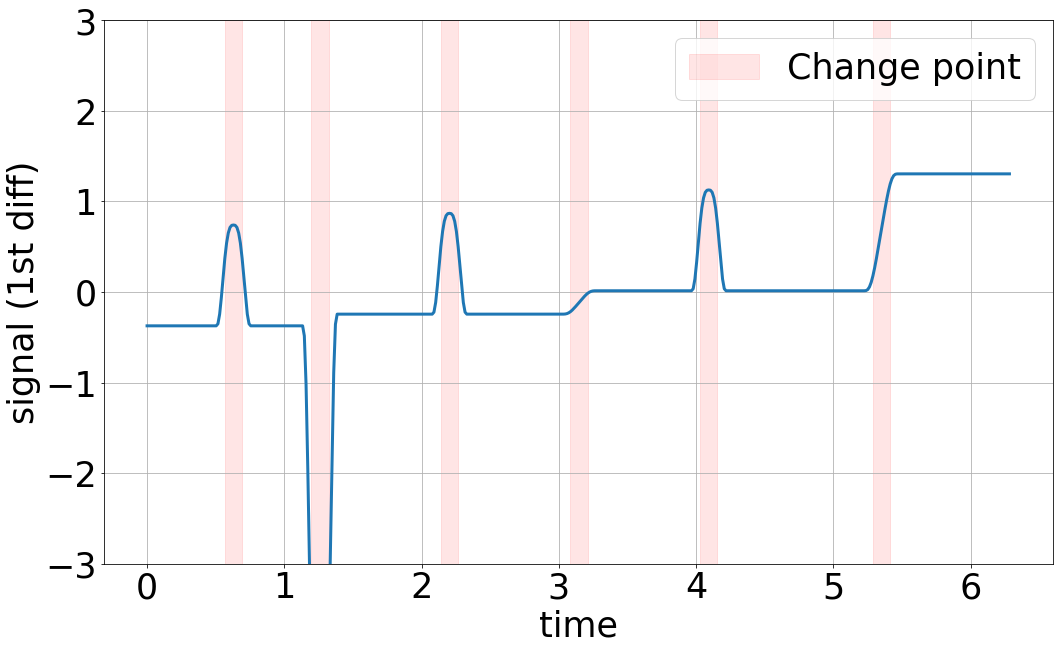

In [7]:
plt.figure(figsize=(17,10))
diff_preprocessor = make_pipeline(DiffTransformer(order=1), LowessSmoothTransformer(args.diff_smooth), StandardScaler())
for d in range(D):
    plt.clf()
    plt.plot(ts, diff_preprocessor.fit_transform(X)[:, d], **plot_args)
    plt.ylim(-3,3)
    plt.ylabel('signal (1st diff)')
    plt.xlabel('time')
    plt.grid()

    for point in np.argwhere(y==1).squeeze():
        plt.axvspan(ts[point-args.margin], ts[point+args.margin], alpha=0.1, color='red', label='Change point')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    wandb.log({f"Data/first_diff (dim {d})": wandb.Image(plt2pil())})

# Evaluate baselines

## TIRE

In [8]:
from TIRE import DenseTIRE as TIRE

seq_length = 4500
dim = X.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TIRE(dim).to(device)

model.fit(X, epoches=1000)

dissimilarities, change_point_scores = model.predict(ts)

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Loss: 257.20:   0%|          | 3/1000 [00:00<00:45, 21.89it/s]

Training autoencoder for original timeseries


Loss: 0.93:   0%|          | 0/1000 [00:00<?, ?it/s]

Training autoencoder for FFT timeseries


Loss: 0.00: 100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


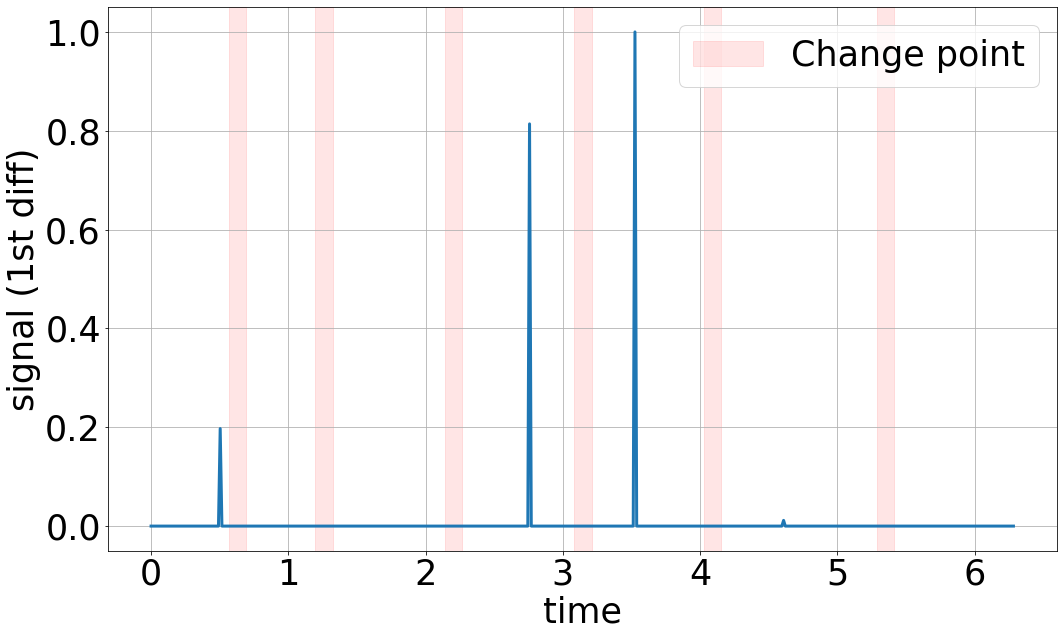

In [9]:
plt.figure(figsize=(17,10))
plt.clf()
plt.plot(ts, change_point_scores, **plot_args)
# plt.ylim(-3,3)
plt.ylabel('signal (1st diff)')
plt.xlabel('time')
plt.grid()

for point in np.argwhere(y==1).squeeze():
    plt.axvspan(ts[point-args.margin], ts[point+args.margin], alpha=0.1, color='red', label='Change point')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

wandb.log({f"Baselines/TIRE/cpd_score": wandb.Image(plt2pil())})

In [10]:
# plt.plot(dissimilarities)
cp_locations = np.argsort(-change_point_scores)
gt = {0: np.argwhere(y>0).squeeze().tolist()}


cov = max([covering(gt, cp_locations[:i], ts.shape[0]) for i in range(cp_locations.shape[0])])
f = max([f_measure(gt, cp_locations[:i]) for i in range(cp_locations.shape[0])])
wandb.log({
    'Baselines/TIRE/F1': f,
    'Baselines/TIRE/Covering': cov,
})

## KL-CPD

In [11]:
from klcpd import KL_CPD

seq_length, dim = X.shape
device = torch.device('cuda')
model = KL_CPD(dim).to(device)
model.fit(X, epoches=1000)
preds = model.predict(ts);

  0%|          | 0/1000 [00:00<?, ?it/s]/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/klcpd/model.py:213: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  noise = Variable(noise, volatile=True) # total freeze netG
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/klcpd/model.py:111: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)
100%|██████████| 1000/1000 [31:53<00:00,  1.91s/it]


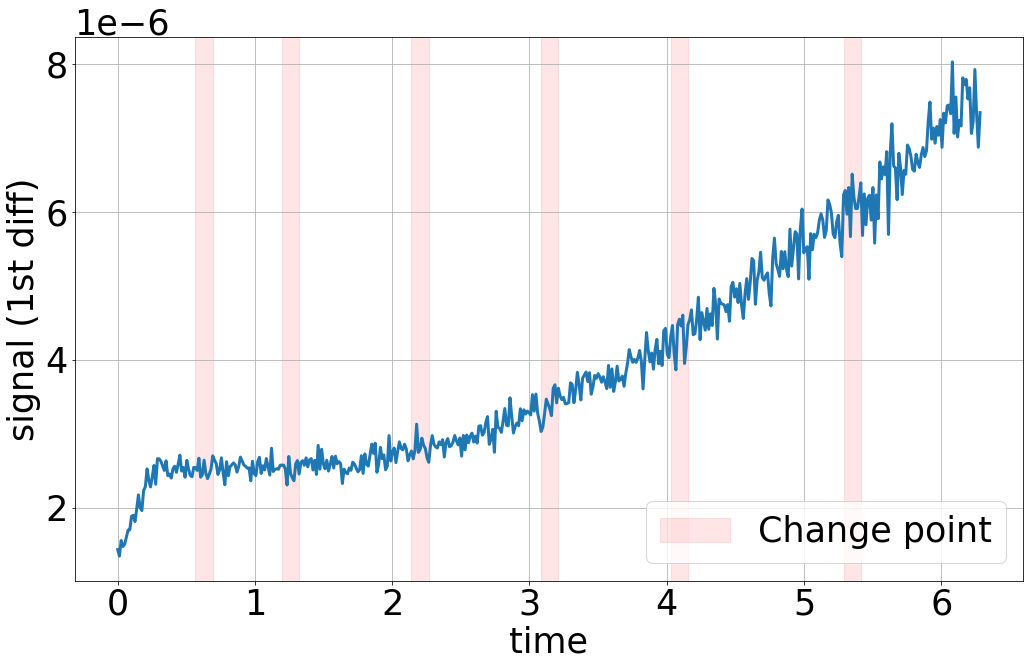

In [12]:
plt.figure(figsize=(17,10))
plt.clf()
plt.plot(ts, preds, **plot_args)
# plt.ylim(-3,3)
plt.ylabel('signal (1st diff)')
plt.xlabel('time')
plt.grid()

for point in np.argwhere(y==1).squeeze():
    plt.axvspan(ts[point-args.margin], ts[point+args.margin], alpha=0.1, color='red', label='Change point')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

wandb.log({f"Baselines/KLCPD/cpd_score": wandb.Image(plt2pil())})

In [13]:
# plt.plot(dissimilarities)
cp_locations = np.argsort(-preds)
gt = {0: np.argwhere(y>0).squeeze().tolist()}


cov = max([covering(gt, cp_locations[:i], ts.shape[0]) for i in range(cp_locations.shape[0])])
f = max([f_measure(gt, cp_locations[:i]) for i in range(cp_locations.shape[0])])
wandb.log({
    'Baselines/KLCPD/F1': f,
    'Baselines/KLCPD/Covering': cov,
})
f, cov

(0.25, 0.2004008708054951)

# ClaSP

In [14]:
from sktime.annotation.clasp import ClaSPSegmentation
model = ClaSPSegmentation(fmt='dense')
model.fit(X[:, 0])
preds = model.predict_scores(X[:, 0])
cpd_scores = np.zeros(X.shape[0])
cpd_scores[-preds.shape[0]:] = preds

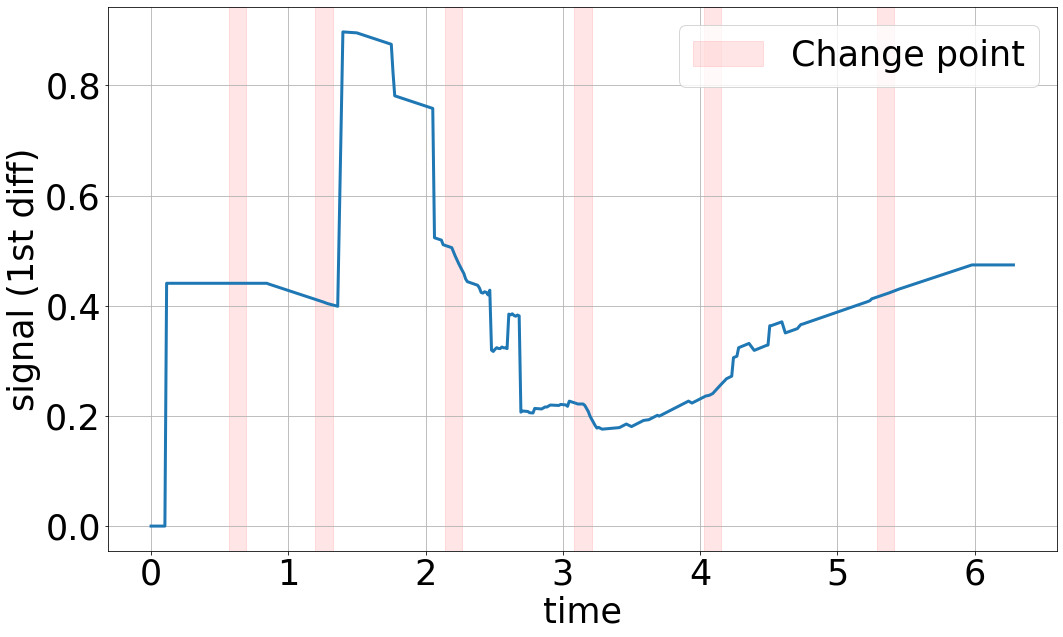

In [15]:
plt.figure(figsize=(17,10))
plt.clf()
plt.plot(ts, cpd_scores, **plot_args)
# plt.ylim(-3,3)
plt.ylabel('signal (1st diff)')
plt.xlabel('time')
plt.grid()

for point in np.argwhere(y==1).squeeze():
    plt.axvspan(ts[point-args.margin], ts[point+args.margin], alpha=0.1, color='red', label='Change point')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

wandb.log({f"Baselines/ClaSP/cpd_score": wandb.Image(plt2pil())})

In [16]:
# plt.plot(dissimilarities)
cp_locations = np.argsort(-cpd_scores)
gt = {0: np.argwhere(y>0).squeeze().tolist()}


cov = max([covering(gt, cp_locations[:i], ts.shape[0]) for i in range(cp_locations.shape[0])])
f = max([f_measure(gt, cp_locations[:i]) for i in range(cp_locations.shape[0])])
wandb.log({
    'Baselines/ClaSP/F1': f,
    'Baselines/ClaSP/Covering': cov,
})
f, cov

(0.25, 0.3259870698872721)

# Train JSDE

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed(args.seed)

X = np.hstack([preprocessor.fit_transform(X) for preprocessor in [preprocessor, diff_preprocessor]]) # bring first diff and original data together
# X = preprocessor.fit_transform(X)

ts, X = [torch.from_numpy(x).to(device).float() for x in [ts, X]]

# Model

In [9]:
bm = torchsde.BrownianInterval(
    t0=ts[0],
    t1=ts[-1],
    size=(args.batch_size, 1),
    device=device,
    levy_area_approximation='space-time'
)  # We need space-time Levy area to use the SRK solver

# Model.
input_size = X.shape[1]
model = LatentSDE(input_size, n_pos_encodings=args.n_pos_encodings).to(device)
optimizer = {'adam': optim.Adam}[args.opt](model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)

logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

wandb.watch(model, criterion=None, log="all", log_freq=100, idx=None,
    log_graph=(False))

tbar = tqdm(range(args.train_iters), desc='???', position=0, leave=True)
plt.figure(figsize=(17,10))

best_f, best_cov = 0., 0.

for global_step in tqdm(range(args.train_iters)):
    # Training
    optimizer.zero_grad()
    zs, kl = model(ts=ts, batch_size=args.batch_size, y0=X[0])
    batch_size = zs.shape[0]

    likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
    
    train_indices = np.arange(X.shape[0])
    
    loss = torch.tensor(0.).to(device)
    
    logpys = []
    
    for d in range(input_size):
        likelihood = likelihood_constructor(loc=zs[:, :, d], scale=args.scale)
        logpy = likelihood.log_prob(X[train_indices, d:d+1]).mean(dim=1)
        logpys.append(logpy.detach().cpu().numpy())
        loss -= logpy.sum(dim=0)
    
    logpy_metric.step(loss)
    kl_metric.step(kl)
    loss += kl * kl_scheduler.val
    loss_metric.step(loss)
    wandb.log({'Train/loss': loss_metric.val,
               'Train/logpy': logpy_metric.val,
               'Train/kl': kl_metric.val,
               'Train/kl_factor': kl_scheduler.val})
    
    loss.backward()
    
    logpys = np.array(logpys).transpose()
    
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()
    
    t = ts.detach().cpu().numpy()
    
    # Visualization
    for d in range(D):
        std_width = 0.3
        plt.clf()
        plt.plot(t, X[train_indices, d].squeeze().detach().cpu().numpy(), alpha=0.5, label='signal', **plot_args)
        sde_pred = zs[:, :, d].squeeze().detach().cpu().numpy()
        plt.plot(t, sde_pred.mean(1), alpha=0.5, label='SDE', c='orange', **plot_args)
        plt.fill_between(t, sde_pred.mean(1)-std_width*sde_pred.std(1), sde_pred.mean(1)+std_width*sde_pred.std(1), facecolor='orange', alpha=0.1, **plot_args)
        for point in np.argwhere(y==1).squeeze():
            plt.axvspan(t[point-args.margin], t[point+args.margin], alpha=0.1, color='red', label='Change point')

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.grid()
        plt.ylabel("signal")
        plt.xlabel("time")
        plt.ylim(-3,3)
        wandb.log({f"Train/SDE (preprocessed data, dim {d})": wandb.Image(plt2pil())})

        plt.clf()
        plt.plot(t, X[train_indices, D+d].squeeze().detach().cpu().numpy(), alpha=0.5, label='signal', **plot_args)
        sde_pred = zs[:, :, D+d].squeeze().detach().cpu().numpy()
        plt.plot(t, sde_pred.mean(1), alpha=0.5, label='SDE', c='orange', **plot_args)
        plt.fill_between(t, sde_pred.mean(1)-std_width*sde_pred.std(1), sde_pred.mean(1)+std_width*sde_pred.std(1), facecolor='orange', alpha=0.1, **plot_args)
        for point in np.argwhere(y==1).squeeze():
            plt.axvspan(t[point-args.margin], t[point+args.margin], alpha=0.1, color='red', label='Change point')

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.grid()
        plt.ylim(-3,3)
        plt.ylabel("signal")
        plt.xlabel("time")

        wandb.log({f"Train/SDE (1st diff, dim {d})": wandb.Image(plt2pil())})


    latent_means, latent_variances = zs.mean(1).detach().cpu().numpy(),  zs.std(1).detach().cpu().numpy()

    def norm_pdf(x, mu, sigma, log=True):
        if log:
            return -(x-mu)**2/(2*sigma**2) - np.log(sigma*np.sqrt(2*np.pi))
        else:
            return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

    data = X.detach().cpu().numpy()
    cpd_score = np.zeros_like(data)

    for lag in range(args.lag):
        cpd_score += norm_pdf(data, latent_means, latent_variances)
        cpd_score[:lag] = 0
        cpd_score[lag:] -= norm_pdf(data[lag:], latent_means[:latent_means.shape[0]-lag], latent_variances[:latent_variances.shape[0]-lag])
    
#     cpd_score = np.exp(cpd_score)
#     cpd_score = (cpd_score > 0) * cpd_score
    cpd_score = np.abs(cpd_score)
    
    
#     cpd_score = cpd_score * (cpd_score > 0)
#     cpd_score = (cpd_score - cpd_score.min(0))/(cpd_score.max(0)-cpd_score.min(0))
    if args.postprocessing:
        for i in range(cpd_score.shape[1]):
            cpd_score[:, i] = prominence_preprocessing(cpd_score[:, i])

    
    for d in range(cpd_score.shape[1]):
        plt.clf()
        plt.plot(t, cpd_score[:, d], alpha=0.5, label='CPD score', **plot_args)
        for point in np.argwhere(y==1).squeeze():
            plt.axvspan(t[point-args.margin], t[point+args.margin], alpha=0.1, color='red', label='Change point')
        #     plt.yscale('log')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.ylim(0, 1)
        plt.legend(by_label.values(), by_label.keys())
        plt.grid()
        wandb.log({f"Preds/CPD score ({d})": wandb.Image(plt2pil())})

    cpd_score = cpd_score.max(1)
    plt.clf()
    plt.plot(t, cpd_score, alpha=0.5, label='CPD score', **plot_args)
    for point in np.argwhere(y==1).squeeze():
        plt.axvspan(t[point-args.margin], t[point+args.margin], alpha=0.1, color='red', label='Change point')
    #     plt.yscale('log')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.ylim(0,1)
    plt.legend(by_label.values(), by_label.keys())
    plt.grid()
    wandb.log({f"Preds/CPD score": wandb.Image(plt2pil())})

    cp_locations = np.argsort(-cpd_score)
    gt = {0: np.argwhere(y>0).squeeze().tolist()}
    cov = max([covering(gt, cp_locations[:i], ts.shape[0]) for i in range(cp_locations.shape[0])])
    f = max([f_measure(gt, cp_locations[:i]) for i in range(cp_locations.shape[0])])

    if cov > best_cov:
        best_cov = cov
        # Save checkpoints
    if f > best_f:
        best_f = f

    wandb.log({
        'Metrics/F1': f,
        'Metrics/Covering': cov,
        'Metrics/Best_F1': best_f,
        'Metrics/Best_Covering': best_cov
    })

    
    tbar.set_description(f"Best F1: {best_f:.3f}\t Best Cov: {best_cov:.3f}")
    tbar.refresh() # to show immediately the update
    